In [1]:
import matplotlib
#matplotlib.use('Agg')
path_data = '../../../assets/data/'
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
import scipy.stats as stats
plt.style.use('fivethirtyeight')

# The Accuracy of the Classifier
To see how well our classifier does, we might put 50% of the data into the training set and the other 50% into the test set.  Basically, we are setting aside some data for later use, so we can use it to measure the accuracy of our classifier.  We've been calling that the *test set*. Sometimes people will call the data that you set aside for testing a *hold-out set*, and they'll call this strategy for estimating accuracy the *hold-out method*.

Note that this approach requires great discipline.  Before you start applying machine learning methods, you have to take some of your data and set it aside for testing.  You must avoid using the test set for developing your classifier: you shouldn't use it to help train your classifier or tweak its settings or for brainstorming ways to improve your classifier.  Instead, you should use it only once, at the very end, after you've finalized your classifier, when you want an unbiased estimate of its accuracy.

In [2]:
def distance(point1, point2):
    """Returns the distance between point1 and point2
    where each argument is an array 
    consisting of the coordinates of the point"""
    return np.sqrt(np.sum((point1 - point2)**2))

def all_distances(training, new_point):
    """Returns an array of distances
    between each point in the training set
    and the new point (which is a row of attributes)"""
    attributes = training.drop('Class')
    def distance_from_point(row):
        return distance(np.array(new_point), np.array(row))
    return attributes.apply(distance_from_point)

def table_with_distances(training, new_point):
    """Augments the training table 
    with a column of distances from new_point"""
    return training.with_column('Distance', all_distances(training, new_point))

def closest(training, new_point, k):
    """Returns a table of the k rows of the augmented table
    corresponding to the k smallest distances"""
    with_dists = table_with_distances(training, new_point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

def majority(topkclasses):
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, new_point, k):
    closestk = closest(training, new_point, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

In [3]:
wine = Table.read_table(path_data + 'wine.csv')

# For converting Class to binary

def is_one(x):
    if x == 1:
        return 1
    else:
        return 0
    
wine = wine.with_column('Class', wine.apply(is_one, 0))

## Measuring the Accuracy of Our Wine Classifier
OK, so let's apply the hold-out method to evaluate the effectiveness of the $k$-nearest neighbor classifier for identifying wines.  The data set has 178 wines, so we'll randomly permute the data set and put 89 of them in the training set and the remaining 89 in the test set.

In [4]:
shuffled_wine = wine.sample(with_replacement=False) 
training_set = shuffled_wine.take(np.arange(89))
test_set  = shuffled_wine.take(np.arange(89, 178))

We'll train the classifier using the 89 wines in the training set, and evaluate how well it performs on the test set. To make our lives easier, we'll write a function to evaluate a classifier on every wine in the test set:

In [5]:
def count_zero(array):
    """Counts the number of 0's in an array"""
    return len(array) - np.count_nonzero(array)

def count_equal(array1, array2):
    """Takes two numerical arrays of equal length
    and counts the indices where the two are equal"""
    return count_zero(array1 - array2)

def evaluate_accuracy(training, test, k):
    test_attributes = test.drop('Class')
    def classify_testrow(row):
        return classify(training, row, k)
    c = test_attributes.apply(classify_testrow)
    return count_equal(c, test.column('Class')) / test.num_rows

Now for the grand reveal -- let's see how we did.  We'll arbitrarily use $k=5$.

In [6]:
evaluate_accuracy(training_set, test_set, 5)

0.898876404494382

The accuracy rate isn't bad at all for a simple classifier.

## Breast Cancer Diagnosis

Now I want to do an example based on diagnosing breast cancer.  I was inspired by Brittany Wenger, who won the Google national science fair in 2012 as a 17-year old high school student.  Here's Brittany:

![Brittany Wenger](http://i.huffpost.com/gen/701499/thumbs/o-GSF83-570.jpg?3)

Brittany's [science fair project](https://sites.google.com/a/googlesciencefair.com/science-fair-2012-project-64a91af142a459cfb486ed5cb05f803b2eb41354-1333130785-87/home) was to build a classification algorithm to diagnose breast cancer.  She won grand prize for building an algorithm whose accuracy was almost 99%. 

Let's see how well we can do, with the ideas we've learned in this course.

So, let me tell you a little bit about the data set.  Basically, if a woman has a lump in her breast, the doctors may want to take a biopsy to see if it is cancerous.  There are several different procedures for doing that.  Brittany focused on fine needle aspiration (FNA), because it is less invasive than the alternatives.  The doctor gets a sample of the mass, puts it under a microscope, takes a picture, and a trained lab tech analyzes the picture to determine whether it is cancer or not.  We get a picture like one of the following:

![benign](../../../images/benign.png)

![cancer](../../../images/malignant.png)

Unfortunately, distinguishing between benign vs malignant can be tricky.  So, researchers have studied the use of machine learning to help with this task.  The idea is that we'll ask the lab tech to analyze the image and compute various attributes: things like the typical size of a cell, how much variation there is among the cell sizes, and so on.  Then, we'll try to use this information to predict (classify) whether the sample is malignant or not.  We have a training set of past samples from women where the correct diagnosis is known, and we'll hope that our machine learning algorithm can use those to learn how to predict the diagnosis for future samples.

We end up with the following data set.  For the "Class" column, 1 means malignant (cancer); 0 means benign (not cancer).

In [7]:
patients = Table.read_table(path_data + 'breast-cancer.csv').drop('ID')
patients

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,1,1,1,2,1,3,1,1,0
5,4,4,5,7,10,3,2,1,0
3,1,1,1,2,2,3,1,1,0
6,8,8,1,3,4,3,7,1,0
4,1,1,3,2,1,3,1,1,0
8,10,10,8,7,10,9,7,1,1
1,1,1,1,2,10,3,1,1,0
2,1,2,1,2,1,3,1,1,0
2,1,1,1,2,1,1,1,5,0
4,2,1,1,2,1,2,1,1,0


So we have 9 different attributes.  I don't know how to make a 9-dimensional scatterplot of all of them, so I'm going to pick two and plot them:

In [8]:
color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)
patients_with_colors = patients.join('Class', color_table)

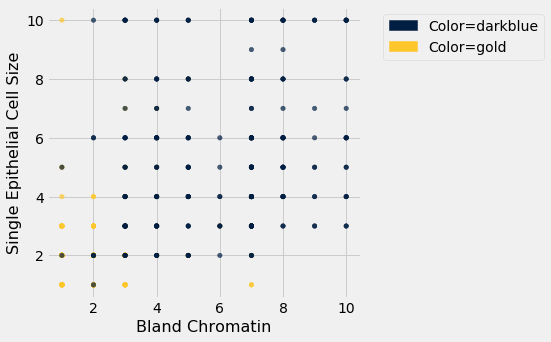

In [9]:
patients_with_colors.scatter('Bland Chromatin', 'Single Epithelial Cell Size', group='Color')

Oops.  That plot is utterly misleading, because there are a bunch of points that have identical values for both the x- and y-coordinates.  To make it easier to see all the data points, I'm going to add a little bit of random jitter to the x- and y-values.  Here's how that looks:

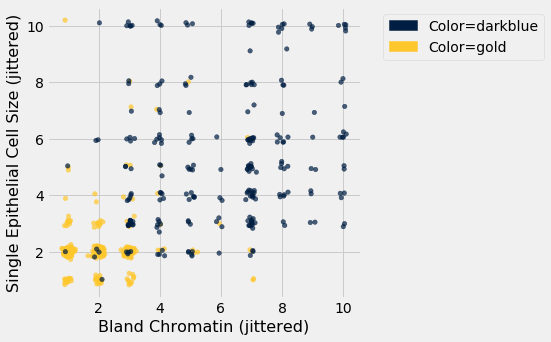

In [10]:
def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))
Table().with_columns(
        'Bland Chromatin (jittered)', 
        randomize_column(patients.column('Bland Chromatin')),
        'Single Epithelial Cell Size (jittered)', 
        randomize_column(patients.column('Single Epithelial Cell Size')),
        'Class', patients.column('Class')
    ).join('Class', color_table).scatter(1, 2, group='Color')

For instance, you can see there are lots of samples with chromatin = 2 and epithelial cell size = 2; all non-cancerous.

Keep in mind that the jittering is just for visualization purposes, to make it easier to get a feeling for the data.  We're ready to work with the data now, and we'll use the original (unjittered) data.

First we'll create a training set and a test set. The data set has 683 patients, so we'll randomly permute the data set and put 342 of them in the training set and the remaining 341 in the test set.

In [11]:
shuffled_patients = patients.sample(683, with_replacement=False) 
training_set = shuffled_patients.take(np.arange(342))
test_set  = shuffled_patients.take(np.arange(342, 683))

Let's stick with 5 nearest neighbors, and see how well our classifier does.

In [12]:
evaluate_accuracy(training_set, test_set, 5)

0.967741935483871

Over 96% accuracy.  Not bad!  Once again, pretty darn good for such a simple technique.

As a footnote, you might have noticed that Brittany Wenger did even better.  What techniques did she use? One key innovation is that she incorporated a confidence score into her results: her algorithm had a way to determine when it was not able to make a confident prediction, and for those patients, it didn't even try to predict their diagnosis.  Her algorithm was 99% accurate on the patients where it made a prediction -- so that extension seemed to help quite a bit.